In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix


In [2]:
# Load dataset

df = pd.read_csv("hospitaldata.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,_Other,Referral,1,Other,...,No,No,No,No,No,No,No,No,No,No
1,149190,55629189,Caucasian,Female,[10-20),Unknown,Home,Emergency,3,Other,...,No,No,Up,No,No,No,No,Yes,Yes,After30Days
2,64410,86047875,AfricanAmerican,Female,[20-30),Unknown,Home,Emergency,2,Other,...,No,No,No,No,No,No,No,No,Yes,No
3,500364,82442376,Caucasian,Male,[30-40),Unknown,Home,Emergency,2,Other,...,No,No,Up,No,No,No,No,Yes,Yes,No
4,16680,42519267,Caucasian,Male,[40-50),Unknown,Home,Emergency,1,Other,...,No,No,Steady,No,No,No,No,Yes,Yes,No


In [3]:
# Display basic info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101763 non-null  int64 
 1   patient_nbr               101763 non-null  int64 
 2   race                      101763 non-null  object
 3   gender                    101763 non-null  object
 4   age                       101763 non-null  object
 5   weight                    101763 non-null  object
 6   discharge_disposition_id  101763 non-null  object
 7   admission_source_id       101763 non-null  object
 8   time_in_hospital          101763 non-null  int64 
 9   medical_specialty         101763 non-null  object
 10  num_lab_procedures        101763 non-null  int64 
 11  num_procedures            101763 non-null  int64 
 12  num_medications           101763 non-null  int64 
 13  number_outpatient         101763 non-null  int64 
 14  numb

In [4]:
df.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017630e+05,1.017630e+05,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,1.652008e+08,5.432965e+07,4.396018,43.095909,1.339691,16.021835,0.369368,0.197842,0.635585,7.422649
std,1.026410e+08,3.869658e+07,2.985092,19.674220,1.705792,8.127589,1.267282,0.930485,1.262877,1.933578
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.495975e+07,2.341296e+07,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523883e+08,4.550049e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302698e+08,8.754571e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [5]:
# Check missing values
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose  

In [6]:
# Convert target variable 'readmitted' into binary (1 for 'Yes', 0 for 'No')
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x in ['Within30Days', 'After30Days'] else 0)

In [7]:
# Separate categorical and numerical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove("readmitted")  # Exclude target variable

readmitted
0    54861
1    46902
Name: count, dtype: int64


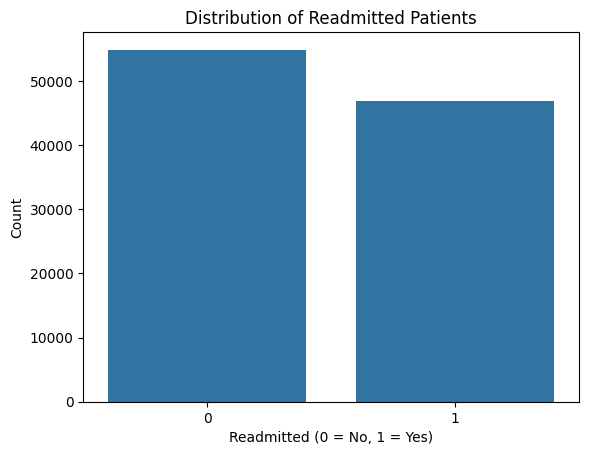

In [8]:
# Check the distribution of the target variable
print(df['readmitted'].value_counts())

# Visualize class distribution
sns.countplot(x=df['readmitted'])
plt.title("Distribution of Readmitted Patients")
plt.xlabel("Readmitted (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


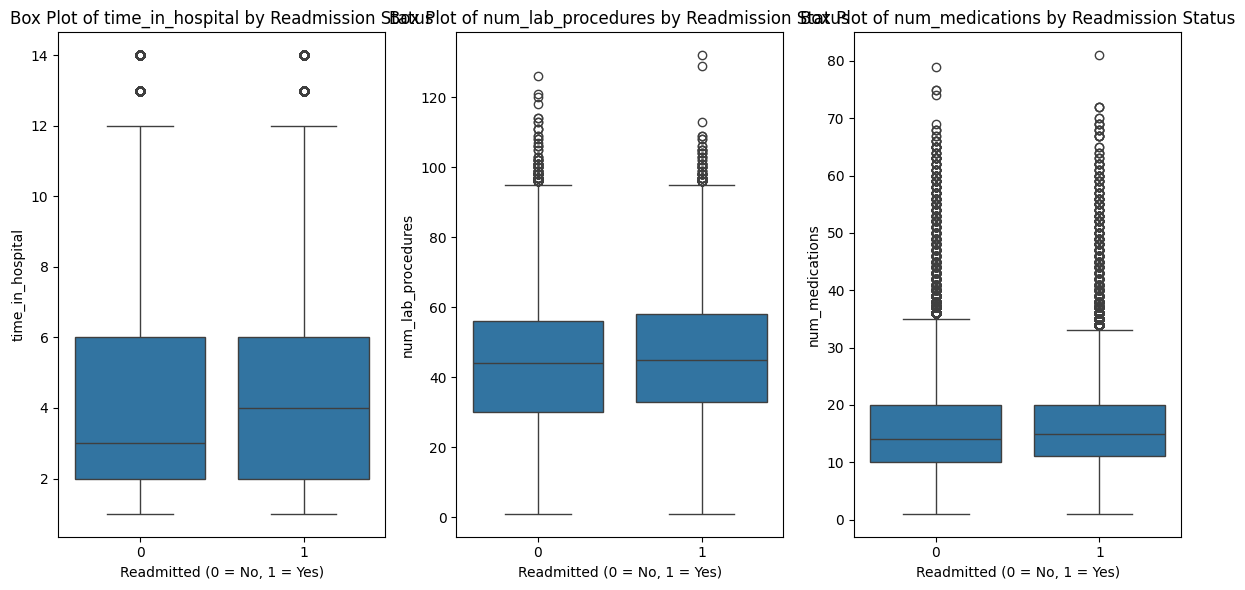

In [9]:
# Select numerical features for comparison
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_medications']

# Create box plots for each numerical feature grouped by readmission status
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df['readmitted'], y=df[feature])
    plt.title(f'Box Plot of {feature} by Readmission Status')
    plt.xlabel('Readmitted (0 = No, 1 = Yes)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

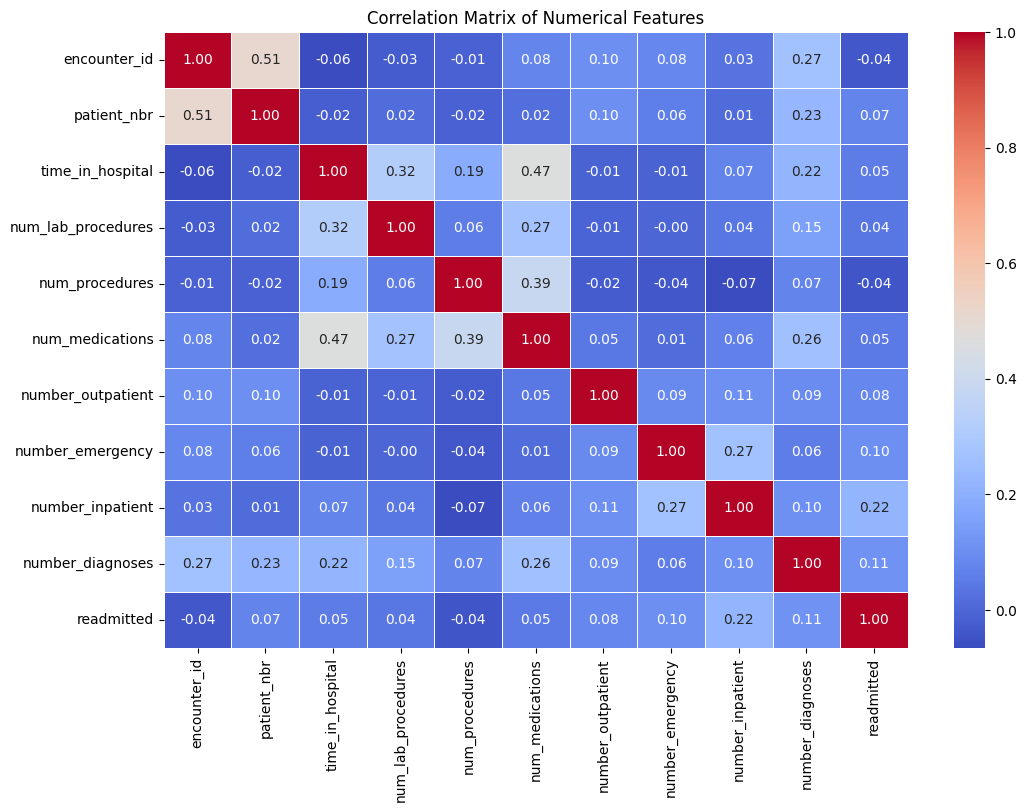

In [11]:
# Select only numerical features
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
correlation_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [7]:
# Preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [8]:
# Train-test split and i will use 20% data for testing
X = df.drop(columns=['readmitted'])
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Logistic Regression Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])


In [10]:
# Hyper Parameter Tuning
param_grid = {
    'classifier__C': [0.1, 1, 10],  
    'classifier__penalty': ['l2']
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['encounter_id',
                                                                          'patient_nbr',
                                                                          'time_in_hospital',
                                                                          'num_lab_procedures',
                                                                          'num_procedures',
                                                                          'num_medications',
                                                                          'number_outpatient',
                                                                          'number_emergency',
                                                                          'number_inpatient',
                                                                          'number_diagno...
                                                                          'acetohexamide',
                                                                          'glipizide',
                                                                          'glyburide',
                                                                          'tolbutamide',
                                                                          'pioglitazone',
                                                                          'rosiglitazone',
                                                                          'acarbose',
                                                                          'miglitol',
                                                                          'troglitazone',
                                                                          'tolazamide',
                                                                          'examide',
                                                                          'citoglipton',
                                                                          'insulin', ...])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l2']},
             scoring='roc_auc')

In [11]:
# Best Model Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67     11016
           1       0.61      0.61      0.61      9337

    accuracy                           0.65     20353
   macro avg       0.64      0.64      0.64     20353
weighted avg       0.65      0.65      0.65     20353



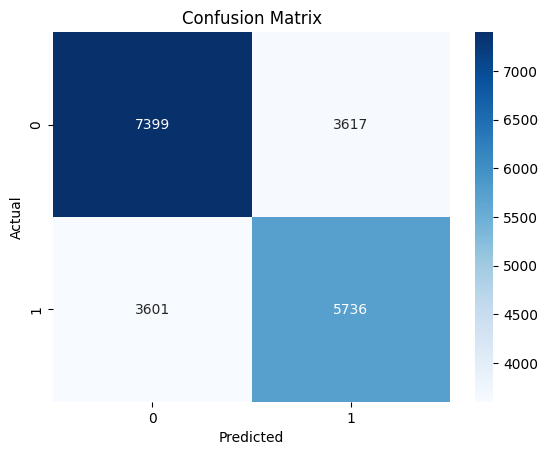

In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Fig 1 : Confusion Matrix showing predicted vs. actual readmission outcomes.

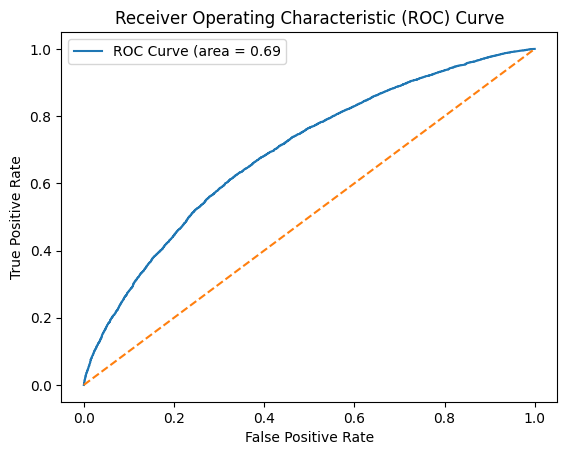

In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

Fig 2: ROC Curve illustrating model performance with AUC score